In [1]:
import sys
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sindy_utils import library_size, sindy_library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, LassoCV


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.11 from "c:\Users\USAID\AppData\Local\Programs\Python\Python311\python.exe"
  * The NumPy version is: "1.25.2"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The paging file is too small for this operation to complete.


In [2]:
# Dynamical systems Functions

def lorenz(X, t, s=10, r=28, b=8/3):
    """Lorenz system."""
    x, y, z = X
    return [s*(y-x), x*(r-z)-y, x*y-b*z]

def rossler(X, t, a=0.2, b=0.2, c=5.7):
    """Rossler system."""
    x, y, z = X
    return -y-z, x+a*y, b+z*(x-c)

def lotka_volterra(X, t, a=1.5, b=1, c=3, d=1):
    """Lotka-Volterra system."""
    x, y = X
    return a*x - b*x*y, -c*y + d*x*y

##
def chua(X, a=15.6, b=28, m=0.2):
    """Chua system."""
    x, y, z = X
    return a*(y-x-m*x**3), x - y + z, -b*y


def chen(X, a=35, c=27, b=2.8):
    """Chua system."""
    x, y, z = X
    return a*(y-x), (c-a)*x - z*x + c*y, x*y - b*z

def henon(X, t, a=1.4, b=0.3):
    """Henon map."""
    x, y = X
    return 1 - a*x**2 + y, b*x

# Build hankel matrix from time series 1D 
def build_hankel_matrix(x, delay=30):
    """Build a Hankel matrix from a time series."""
    N = len(x)
    M = N - delay - 1
    hankel = np.zeros((delay, M))
    for i in range(delay):
        hankel[i, :] = x[i:i+M]
    return hankel

# Generate a time series for each of the dynamical systems above using scipy.integrate.odeint
from scipy.integrate import odeint

def generate_time_series(func, x0, t, args=()):
    """Generate a time series for a given dynamical system."""
    return odeint(func, x0, t).T


### Map dominant SVD modes from Hankel matrix to x

Let $\mathbf x(t)$ the solution of a dynamical system

$$ \frac{d\mathbf x}{dt} = \mathbf f_\mathbf{w}(x) $$

Let $H$ be the Hankel matrix with every column defined as 

$$\mathbf h(x_i; n, \tau) = [x_i(t), x_i(t + \tau), \ldots, x_i(t + (n-1)\tau)]$$

We find the dominant eigen-time modes of the time-delay embedding of $x$ using the SVD decomposition:

$$ H = U \Sigma V^T $$

We use the $k$ dominant time modes

$$ V_k = V[:, :k] $$

We seek a polynomial map between $V_k$ and $\mathbf x$.

$$ \mathbf x = \boldsymbol \Phi_\mathbf{\bar w}(V_k) = \boldsymbol \Theta(V_k) \mathbf{\bar w}$$


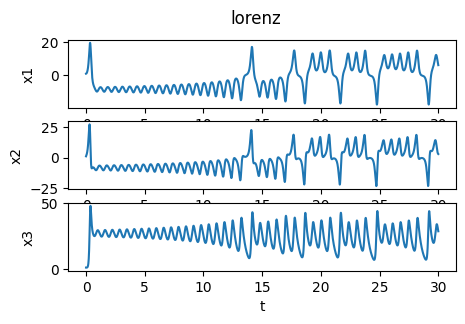

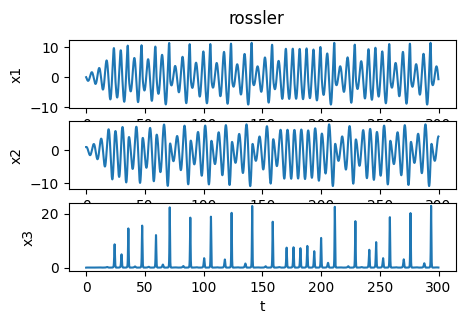

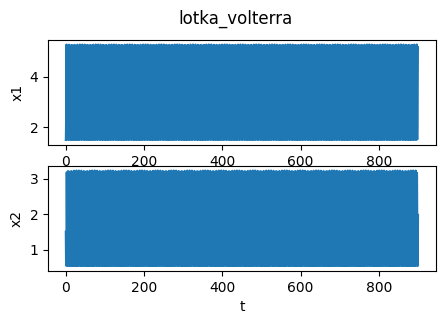

In [3]:
# %matplotlib widget

# Dynamical systems parameters
systems = [lorenz, rossler, lotka_volterra]#, chen]
x0s = [(1, 1.0, 1.0), (0, 1, 0), (1.5, 1.5)]#, (-0.1, 0.3, -0.6)] 
ndts = [0.1, 1, 3]#, .01] # n*dt is roughly the period of oscillation
num_step_per_period = 13 # number of time steps per period
periods = 300 # number of periods to simulate
ts = [np.linspace(0, int(periods*ndt), int(periods*num_step_per_period), endpoint=False) for i, ndt in enumerate(ndts)]
args = [() for i in range(len(systems))]

# SINDy parameters
plot_systems = True
poly_order = 3
nd = 3
delay = num_step_per_period
alpha = 0.4
project = False

usesine = False

# Training parameters
test_size = 0.2
random_state = 0

# Plot systems and their corresponding time series 
if plot_systems:
    for i, system in enumerate(systems):
        # generate time series
        X = generate_time_series(system, x0s[i], ts[i], args[i])
        # plot time series
        fig, ax = plt.subplots(len(x0s[i]), 1, figsize=(5, 3))
        for j in range(len(x0s[i])):
            ax[j].plot(ts[i], X[j, :])
            ax[j].set_xlabel('t')
            ax[j].set_ylabel('x{}'.format(j+1))
        plt.suptitle(system.__name__)
        plt.show()

In [4]:
# 1. Loop through dynamical systems models,
# 2. generate time series, and build hankel matrices
# 3. for each time series apply SVD to get the basis vectors (k rows of VT)
# 4. Then build a polynomial library in VT_k 
# 5. Train a linear model to fit the library to the original full-state time series


# Loop through dynamical systems
results = []
for system, x0, t, arg in zip(systems, x0s, ts, args):
    # Generate time series

    x = generate_time_series(system, x0, t, arg)

    # project on random vector
    if project:
        n = np.random.randn(x.shape[0])
        n = n/np.linalg.norm(n)
        xp = np.sum(x * n[:, None], axis=0)
    else:
        xp = x[0, :]
        n = None
    
    # Build hankel matrix
    H = build_hankel_matrix(xp, delay)

    # SVD
    U, s, VT = np.linalg.svd(H, full_matrices=False)

    v = np.matmul(VT[:nd, :].T, np.diag(s[:nd]))

    # Build polynomial library Assuming nd dominant modes
    X, names = sindy_library(v, poly_order, include_names=True, include_sine=False)


    # Split data into training and testing sets
    x_train, x_test, library_train, library_test = train_test_split(x[:, :X.shape[0]].T, X, 
                                                test_size=test_size, random_state=random_state,
                                                shuffle=False)
    
    
    # Train linear model
    model = Lasso(alpha=alpha, fit_intercept=False, max_iter=50000)
    model.fit(library_train, x_train)
    # print(model.coef_)

    # Evaluate model
    x_pred = model.predict(library_test)

    # Compute error
    error = np.linalg.norm(x_pred - x_test)/np.linalg.norm(x_test)
    score = model.score(library_test, x_test)
    num_zeros = np.sum(model.coef_ == 0.0)

    print('## ', system.__name__)
    print("Error: %f" % error)
    print("Score: %f" % score)

    print('sparsity : ', num_zeros/(np.prod(model.coef_.shape)))
    print('----')

    # Store results in list
    results.append((system.__name__, x_train, x_test, x_pred, 
        library_train, library_test, model, error, score, names, model.coef_, v, n))



##  lorenz
Error: 0.172842
Score: 0.902704
sparsity :  0.3333333333333333
----
##  rossler
Error: 0.120893
Score: 0.970505
sparsity :  0.3333333333333333
----
##  lotka_volterra
Error: 0.016600
Score: 0.998325
sparsity :  0.675
----


[[-0.00000000e+00 -2.67942952e-01 -2.66312958e-01  0.00000000e+00
  -3.34921671e-06 -1.48710290e-04  2.45157556e-04  0.00000000e+00
   0.00000000e+00 -0.00000000e+00 -5.09068073e-06 -1.23236146e-04
   4.47034253e-04 -5.60864298e-05  2.87519701e-03 -6.75290790e-03
   0.00000000e+00  3.44578770e-03 -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -1.98414769e-01  5.74051248e-01 -0.00000000e+00
  -1.91271555e-05  1.75505763e-04  0.00000000e+00  0.00000000e+00
  -0.00000000e+00  0.00000000e+00 -7.53696346e-05 -1.89226219e-04
   7.98054288e-04  3.15871968e-04  5.73337883e-04 -3.79662284e-03
  -2.36179644e-04 -1.06214596e-02  0.00000000e+00 -0.00000000e+00]
 [ 1.85489307e+01  1.05070319e-01 -0.00000000e+00  0.00000000e+00
   6.77093953e-03  4.97576572e-02 -1.24072320e-01 -3.40692387e-02
  -1.07841661e+00  0.00000000e+00 -6.70528232e-05 -4.81933714e-05
   1.65692014e-03  4.37901119e-05 -2.78596353e-03 -2.07527608e-02
   7.96793040e-04 -1.42642509e-03 -5.88848091e-02 -0.00000000e+00]]
[[ 0.0

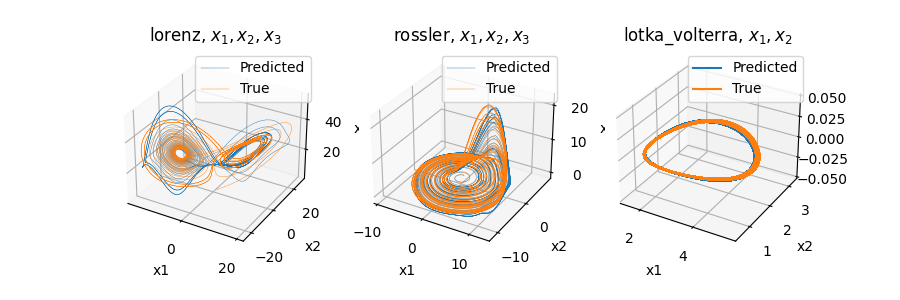

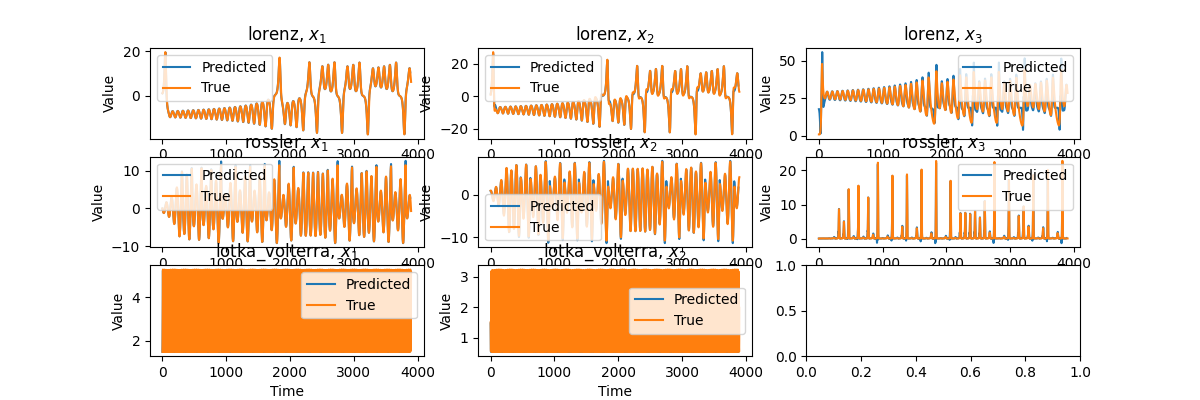

In [5]:
%matplotlib widget
# import numpy as np
# Plot results till time 10
iend = 50000 
# Plot results
fig1, axes = plt.subplots(len(systems), 3, figsize=(12, 4))
fig2 = plt.figure(figsize=(9, 3))

for i, (name, x_train, x_test, x_pred, library_train, library_test, model, error, score, names, coef, v, n) in enumerate(results):
    if i >3:
        continue
    ax3d = fig2.add_subplot(1, 3, i+1, projection='3d')

    nper = 1.0
    t = np.linspace(0, int(nper*periods*ndts[i]), int(nper*periods*num_step_per_period), endpoint=False)
    x = generate_time_series(systems[i], x0s[i], t, args[i])

    if project:
        xp = np.sum(x * n[:, None], axis=0)
    else:
        xp = x[0, :]

    H = build_hankel_matrix(xp, delay)
    U, s, VT = np.linalg.svd(H, full_matrices=False)
    v = np.matmul(VT[:nd, :].T, np.diag(s[:nd]))
    X, names = sindy_library(v, poly_order, include_names=True, include_sine=False)
    x_pred = model.predict(X).T

    print(model.coef_)

    for j in range(x_test.shape[1]):

        axes[i, j].plot(x_pred[j, :iend], label='Predicted')
        axes[i, j].plot(x[j, :iend], label='True')
        axes[i, j].set_title("%s, $x_%d$" % (name, j+1))
        axes[i, j].set_xlabel("Time")
        axes[i, j].set_ylabel("Value")
        axes[i, j].legend()
            
    if x_test.shape[1] == 3:
        ax3d.plot(x_pred[0, :iend], x_pred[1, :iend], x_pred[2, :iend], lw=.3,label='Predicted')
        ax3d.plot(x[0, :iend], x[1, :iend], x[2, :iend], lw=.3,label='True')
        ax3d.set_title("%s, $x_1, x_2, x_3$" % (name))
        ax3d.set_xlabel("x1")
        ax3d.set_ylabel("x2")
        ax3d.set_zlabel("x3")
        ax3d.legend()

    elif x_test.shape[1] == 2:
        ax3d.plot(x_pred[0, :], x_pred[1, :], label='Predicted')
        ax3d.plot(x[0, :x_pred.shape[1]], x[1, :x_pred.shape[1]], label='True')
        ax3d.set_title("%s, $x_1, x_2$" % (name))
        ax3d.set_xlabel("x1")
        ax3d.set_ylabel("x2")
        ax3d.legend()


# plt.tight_layout()
plt.show()



In [6]:
results[1][10]

array([[ 0.00000000e+00, -2.51463387e-01, -3.91505943e-01,
         0.00000000e+00, -6.48030145e-05, -1.02261756e-03,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -8.93575513e-06, -4.51574619e-05,
         2.52994186e-04,  2.46026703e-04, -3.17682891e-03,
         4.38989384e-03, -4.45910341e-04,  5.43526919e-03,
        -0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.60925608e-02, -7.60370138e-01,
        -0.00000000e+00, -3.52419206e-04, -4.72482984e-03,
        -0.00000000e+00, -8.25920106e-03,  0.00000000e+00,
        -0.00000000e+00,  5.40401473e-05,  9.04350198e-05,
         7.65369431e-04,  8.52438138e-04,  3.98419607e-03,
        -6.62111619e-03,  8.37870688e-04, -8.82482672e-03,
         5.07695523e-03, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  1.45041179e-03, -1.13708813e-02,
         1.49661624e-01,  2.69573346e-02, -8.36832912e-01,
         0.00000000e+00,  3.6

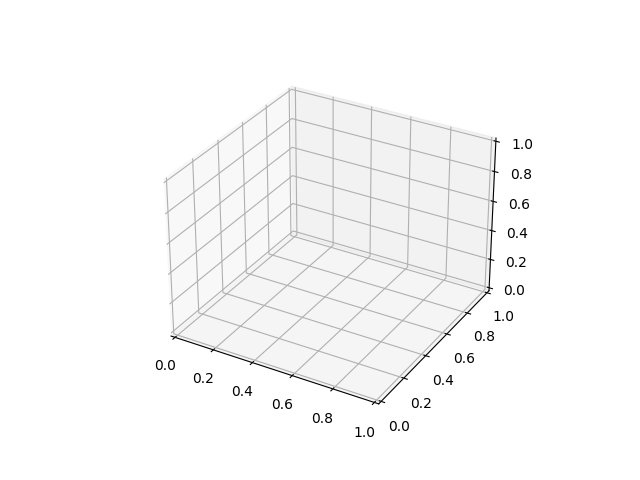

interactive(children=(IntSlider(value=50, description='delay', min=10), FloatSlider(value=0.01, description='d…

<function __main__.f(delay, dt)>

In [7]:
# Interactive plot for the dominant modes of the lorenz hankel matrix (v) changing the number of delays and the time step
# The plot shows the 3D plot of the dominant modes 

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

nd = 3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
def f(delay, dt):
    x = generate_lorenz_data(10000, dt, 10, 28, 8/3)
    print(x.shape)
    H = build_hankel_matrix(x[:, 0], delay)
    U, s, VT = np.linalg.svd(H, full_matrices=False)
    v = np.matmul(VT[:nd, :].T, np.diag(s[:nd]))
    ax.clear() 
    ax.plot(v[:,0], v[:,1], v[:,2], lw=.1)
    ax.set_title("Lorenz dominant modes")
    ax.set_xlabel("$v_1$")
    ax.set_ylabel("$v_2$")
    ax.set_zlabel("$v_3$")
plt.show()

interact(f, delay=widgets.IntSlider(min=10, max=100, step=1, value=50), dt=widgets.FloatSlider(min=0.001, max=0.1, step=0.01, value=0.01))


In [8]:
reduced_dim = 5
params['input_dim'] = reduced_dim

scale = False
svd_data.x = np.matmul(VT[:reduced_dim, :].T, np.diag(s[:reduced_dim]))
# svd_data.x = np.matmul(data.x, np.matmul(U[:, :reduced_dim], np.diag(1/s[:reduced_dim])))

scale = False
if scale:
    scaler = StandardScaler()
    svd_data.x = scaler.fit_transform(svd_data.x)
    data.z = scaler.fit_transform(data.z)
    
svd_data.dx = np.gradient(svd_data.x, params['dt'], axis=0)
svd_data.ddx = np.gradient(svd_data.dx, params['dt'], axis=0)
svd_data.sindy_coefficients = data.sindy_coefficients


NameError: name 'params' is not defined

In [ ]:
fig = plt.figure()
i = 200000
j = 1000
ax = fig.add_subplot(111, projection='3d')
ax.plot(svd_data.x[j:i, 0], svd_data.x[j:i, 1], svd_data.x[j:i, 2], 'k', lw=0.5)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data.z[j:i, 0], data.z[j:i, 1], data.z[j:i, 2], 'k', lw=0.5)
plt.show()

In [ ]:
i=5
X, names = sindy_library(svd_data.x, i, include_names=True, include_sine=False)
Y = data.z

L = Lasso(alpha=1e-5, fit_intercept=False)
L.fit(X, Y)
z_pred = L.predict(X)

print('degree = ', i)
print('score = ', L.score(X, Y))
print('coefficients = \n', L.coef_)


In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(7, 7))
i = 200000
j = 1000
ax = fig.add_subplot(111, projection='3d')
ax.plot(data.z[j:i, 0], data.z[j:i, 1], data.z[j:i, 2], 'k', lw=0.5)
ax.plot(z_pred[j:i, 0], z_pred[j:i, 1], z_pred[j:i, 2], 'r', lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(0, 120)

fig = plt.figure(figsize=(13, 15))
l = 20000
k = 40000
ax = fig.add_subplot(311)
ax.plot(z_pred[l:k, 0], 'k')
ax.plot(data.z[l:k, 0], 'r')

ax1 = fig.add_subplot(312)
ax1.plot(z_pred[l:k, 1], 'k')
ax1.plot(data.z[l:k, 1], 'r')

ax2 = fig.add_subplot(313)
ax2.plot(z_pred[l:k, 2], 'k')
ax2.plot(data.z[l:k, 2], 'r')

plt.show()

print(X)
print(names)

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(5, 5))
i = 200000
j = 10000
ax = fig.add_subplot(111, projection='3d')
ax.plot(data.z[j:i, 0]-z_pred[j:i, 0], 
        data.z[j:i, 1]-z_pred[j:i, 1],
        data.z[j:i, 2]-z_pred[j:i, 2], 'k', lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(0, 120)
ax.axis('off')

plt.show()

# fig = plt.figure(figsize=(13, 15))
# l = 20000
# k = 40000
# ax = fig.add_subplot(311)
# ax.plot(z_pred[l:k, 0]-data.z[l:k, 0], 'k')

# ax1 = fig.add_subplot(312)
# ax1.plot(z_pred[l:k, 1]-data.z[l:k, 1], 'k')

# ax2 = fig.add_subplot(313)
# ax2.plot(z_pred[l:k, 2]-data.z[l:k, 2], 'k')

# plt.show()

In [ ]:
def make_network(input_dim, output_dim, activation, widths, l2reg, name):
    initializer= tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    for i, w in enumerate(widths):
        model.add(tf.keras.layers.Dense(w, activation=activation, kernel_initializer=initializer, 
                                        name=name+'_'+str(i)))
    model.add(tf.keras.layers.Dense(output_dim, activation='linear', kernel_initializer=initializer, 
                                    activity_regularizer=tf.keras.regularizers.L2(l2reg), 
                                    name=name+'_'+'out'))
    return model

In [ ]:
name = 'error_function'
activation = params['activation']
batch_size = params['batch_size']
epochs = params['max_epochs']
widths = [10, 10, 5]
learning_rate = 2e-3
l2reg = 0.0#1e-7

model_svd2net = make_network(5, 3, activation, widths, l2reg, name)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_svd2net.compile(optimizer=optimizer, loss='mse')

train_data_x, val_data_x, train_data_z, val_data_z = \
train_test_split(svd_data.x, data.z-z_pred, train_size=params['train_ratio'], shuffle=False)

history = model_svd2net.fit(
        x=train_data_x, y=train_data_z, 
        batch_size=params['batch_size'],
        epochs=150, 
        validation_data=(val_data_x, val_data_z),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
        shuffle=True)

In [ ]:
error_pred = model_svd2net.predict(svd_data.x)
z_corrected = z_pred + error_pred


In [ ]:
fig = plt.figure(figsize=(7, 7))
i = 200000
j = 1000
ax = fig.add_subplot(111, projection='3d')
ax.plot(data.z[j:i, 0], data.z[j:i, 1], data.z[j:i, 2], 'k', lw=0.5)
ax.plot(z_corrected[j:i, 0], z_corrected[j:i, 1], z_corrected[j:i, 2], 'r', lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(0, 120)

fig = plt.figure(figsize=(13, 15))
l = 20000
k = 40000
ax = fig.add_subplot(311)
ax.plot(z_corrected[l:k, 0], 'k')
ax.plot(data.z[l:k, 0], 'r')

ax1 = fig.add_subplot(312)
ax1.plot(z_corrected[l:k, 1], 'k')
ax1.plot(data.z[l:k, 1], 'r')

ax2 = fig.add_subplot(313)
ax2.plot(z_corrected[l:k, 2], 'k')
ax2.plot(data.z[l:k, 2], 'r')


### Degrees 2 to 5 with linear regression

In [ ]:

for i in range(2, 6):
    X, names = sindy_library(svd_data.x, i, include_names=True, include_sine=False)
    Y = data.z

    L = LinearRegression(fit_intercept=False)
#     L = Lasso(alpha=1e-5, fit_intercept=False)
    L.fit(X, Y)
    z_pred = L.predict(X)

    print('degree = ', i)
    print('score = ', L.score(X, Y))
    print('coefficients = \n', L.coef_)

    fig = plt.figure(figsize=(10, 10))
    i = 200000
    j = 1000
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(data.z[j:i, 0], data.z[j:i, 1], data.z[j:i, 2], 'k', lw=0.5)
    ax.plot(z_pred[j:i, 0], z_pred[j:i, 1], z_pred[j:i, 2], 'r', lw=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(0, 120)

    fig = plt.figure(figsize=(13, 15))
    l = 20000
    k = 40000
    ax = fig.add_subplot(311)
    ax.plot(z_pred[l:k, 0], 'k')
    ax.plot(data.z[l:k, 0], 'r')

    ax1 = fig.add_subplot(312)
    ax1.plot(z_pred[l:k, 1], 'k')
    ax1.plot(data.z[l:k, 1], 'r')

    ax2 = fig.add_subplot(313)
    ax2.plot(z_pred[l:k, 2], 'k')
    ax2.plot(data.z[l:k, 2], 'r')

    plt.show()


### degrees 2 to 5, with LASSO

In [ ]:
for i in range(2, 6):
    X, names = sindy_library(svd_data.x, i, include_names=True, include_sine=False)
    Y = data.z

#     L = LinearRegression(fit_intercept=False)
    L = Lasso(alpha=1e-5, fit_intercept=False)
    L.fit(X, Y)
    z_pred = L.predict(X)

    print('degree = ', i)
    print('score = ', L.score(X, Y))
    print('coefficients = \n', L.coef_)

    fig = plt.figure(figsize=(10, 10))
    i = 200000
    j = 1000
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(data.z[j:i, 0], data.z[j:i, 1], data.z[j:i, 2], 'k', lw=0.5)
    ax.plot(z_pred[j:i, 0], z_pred[j:i, 1], z_pred[j:i, 2], 'r', lw=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(0, 120)

    fig = plt.figure(figsize=(13, 15))
    l = 20000
    k = 40000
    ax = fig.add_subplot(311)
    ax.plot(z_pred[l:k, 0], 'k')
    ax.plot(data.z[l:k, 0], 'r')

    ax1 = fig.add_subplot(312)
    ax1.plot(z_pred[l:k, 1], 'k')
    ax1.plot(data.z[l:k, 1], 'r')

    ax2 = fig.add_subplot(313)
    ax2.plot(z_pred[l:k, 2], 'k')
    ax2.plot(data.z[l:k, 2], 'r')

    plt.show()